In [1]:
import os, copy, h5py
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
import numpy as np
import pandas as pd
from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import generate_boilerplate_outputfile, extract_unit_dict, temp_dir
from compas_python_utils.cosmic_integration.ClassCOMPAS import COMPASData
from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023, madau_dickinson_sfr
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022, compas_log_skew_normal_distribution_metallicity_distribution
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.cosmology_utils import lookback_time_to_redshift
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict
import matplotlib.pyplot as plt
from population_vis import get_formation_efficiency
import time
import warnings

Load some compas-specific things as well as efficiencies

1 binary in COMPAS represents 79.11015055714887  solar masses formed
20000000
1582203011.1429775  [Msun]
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
Took 0.21670007705688477 to find efficiencies


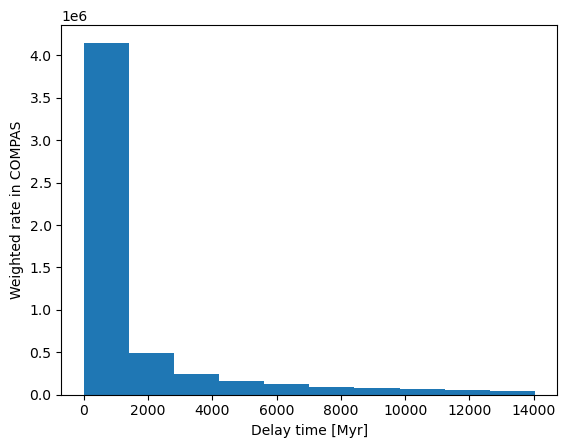

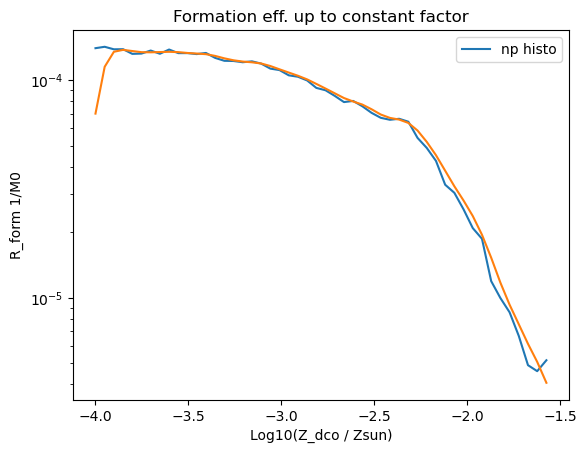

In [2]:
filepath = '/Volumes/Elements/Boesky_sims.h5'

# SET UP DATA -- from a basic dict, port to an h5 file and then store this into the output file
# now we want to use some real data
fdata = h5py.File(filepath)
all_dco_seeds = fdata['BSE_Double_Compact_Objects']['SEED'][()]
all_seeds = fdata['BSE_System_Parameters']['SEED'][()]
metallicities = fdata["BSE_System_Parameters"]["Metallicity@ZAMS(1)"][()]
mixture_weight = fdata["BSE_System_Parameters"]["mixture_weight"][()]
fdata.close()

fe_binned, fe_bins, compasdata = get_formation_efficiency(filepath)
delayTimes = compasdata.delayTimes

# need to get the metallicities as well
dco_query = np.isin(all_seeds, all_dco_seeds[compasdata.DCOmask])
dco_metallicities = metallicities[dco_query]
dco_mixture_weight = mixture_weight[dco_query]
assert len(delayTimes[()]) == len(dco_metallicities), "Something went wrong with masking for dco metallicities"
# to query the probabilties, we can digitize the fe_kde using the dco metallicities
# or just use the kde directly -- TODO: maybe one way is more true than the other?
start_time = time.time()
#dco_efficiencies = fe_kde(dco_metallicities) # this is WAY too slow, have to use bins
dco_efficiencies = fe_binned[np.digitize(np.log10(dco_metallicities), fe_bins) - 1]
print(f'Took {time.time() - start_time} to find efficiencies')

In [3]:
class SFROptions:
    def __init__(self, name, mu0, muz, alpha, w0, wz, a, b, c, d):
        self.name = name
        self.mu0 = mu0
        self.muz = muz
        self.alpha = alpha
        self.w0 = w0
        self.wz = wz
        self.a = a
        self.b = b
        self.c = c
        self.d = d

        # setup SFR binning
        self.num_redshift_bins = 400
        self.redshift_bin_edges = np.linspace(0, 10, self.num_redshift_bins)
        self.redshift_bin_centers = calculate_bincenters(self.redshift_bin_edges)
        # setup metallicity binning
        num_metallicities = 500
        self.log_metallicity_bin_edges = np.linspace(
            # np.log10(np.min(dco_metallicities)),
            # np.log10(np.max(dco_metallicities)),
            -12,0,
            num_metallicities
        )
        self.log_metallicity_bin_centers = calculate_bincenters(self.log_metallicity_bin_edges)
    def __str__(self):
        # return f'{self.mu0}_{self.muz}_{self.alpha}_{self.w0}_{self.wz}_{self.a}_{self.b}_{self.c}_{self.d}'
        return str(self.name)
    def calculate_sfr(self):
        # Set up SFR, and hopefully also setup metallicity dependence
        return madau_dickinson_sfr(
            self.redshift_bin_centers,
            self.a,
            self.b,
            self.c,
            self.d
        ).to(u.Msun/u.yr/u.Gpc**3)
    def calculate_metallicity_distro(self):
        return compas_log_skew_normal_distribution_metallicity_distribution(
            self.redshift_bin_centers,
            self.log_metallicity_bin_centers,
            self.mu0,
            self.muz,
            self.w0,
            self.wz,
            self.alpha
        )
        # return metallicity_distribution_vanSon2022(self.log_metallicity_bin_centers, self.redshift_bin_centers)

sfr_van_son = {
    'fiducial': SFROptions(
        'fiducial',
        0.025,
        -0.049,
        -1.778,
        1.125,
        0.048,
        0.02,
        1.48,
        4.44,
        5.90
    ),
    'min': SFROptions(
        'min',
        0.007,
        -0.5,
        -6.0,
        0.7,
        0.0,
        0.01,
        2.60,
        3.20,
        6.20
    ),
    'max': SFROptions(
        'max',
        0.035,
        0,
        0.0,
        2.0,
        0.1,
        0.03,
        2.6,
        3.3,
        5.9
    )
}
def do_convolve_with_sfr_options(options: SFROptions):
    # sadly, can't really save different SFRs in the same file, so we'll need to create a new one each time
    # Create instance of output
    output_hdf5_filename = f'/Volumes/Elements/sspc_output_{str(options)}.h5'#os.path.join(TMP_DIR, "output_example.h5")
    generate_boilerplate_outputfile(output_hdf5_filename)

    dummy_data = {
            'delay_time': delayTimes[()]*u.Myr,
            'probability': dco_efficiencies,#(10e-4)*np.ones_like(delayTimes[()]),
            'metallicity': np.log10(dco_metallicities) # I wonder if we need to log these as well?
    }
    dummy_df = pd.DataFrame.from_records(dummy_data) # load as dataframe
    dummy_df.to_hdf(output_hdf5_filename, key="input_data/example") # port pandas to hdf

    # Set up global configuration
    convolution_config = copy.copy(default_convolution_config)
    convolution_config["output_filename"] = output_hdf5_filename

    high_res_sfr_dict = {
        "redshift_bin_edges": options.redshift_bin_edges,
        "starformation_rate_array": options.calculate_sfr(),
        "metallicity_bin_edges": options.log_metallicity_bin_edges,
        "metallicity_distribution_array": options.calculate_metallicity_distro(),  # We need to transpose!
    }

    axis_dict = plot_sfr_dict(
        high_res_sfr_dict,
        time_type="redshift",
        metallicity_string="logZ",
        metallicity_distribution_multiply_by_metallicity_bin_sizes=False,
        metallicity_distribution_multiply_by_sfr=False,
        metallicity_distribution_scale="log10",
        metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
        return_axis_dict=True,
        figsize=(8,8),
        fontsize=12,
    )
    axis_dict['fig'].savefig('./sfr.png')

    #TODO: assume PLANK13 fit for now
    convolution_config['SFR_info'] = {
        'lookback_time_bin_edges': Planck13.lookback_time(options.redshift_bin_edges),
        'starformation_rate_array': options.calculate_sfr(), # this may have incorrect units!
        'metallicity_bin_edges': options.log_metallicity_bin_edges,
        'metallicity_distribution_array': options.calculate_metallicity_distro()
    }

    # set up convolution bin edges
    convolution_config["convolution_lookback_time_bin_edges"] = (
        np.arange(0, 14, 0.5) * u.Gyr
    )

    # Set up the convolution instructions
    convolution_config["convolution_instructions"] = [
        {
            **default_convolution_instruction,
            "input_data_name": "example",
            "output_data_name": "conv_output",
            "data_column_dict": {
                "delay_time": "delay_time",
                "normalized_yield": {"column_name": "probability", "unit": 1/u.Msun},
                'metallicity': 'metallicity'
            }
        }
    ]

    # run convolution
    convolve(convolution_config)

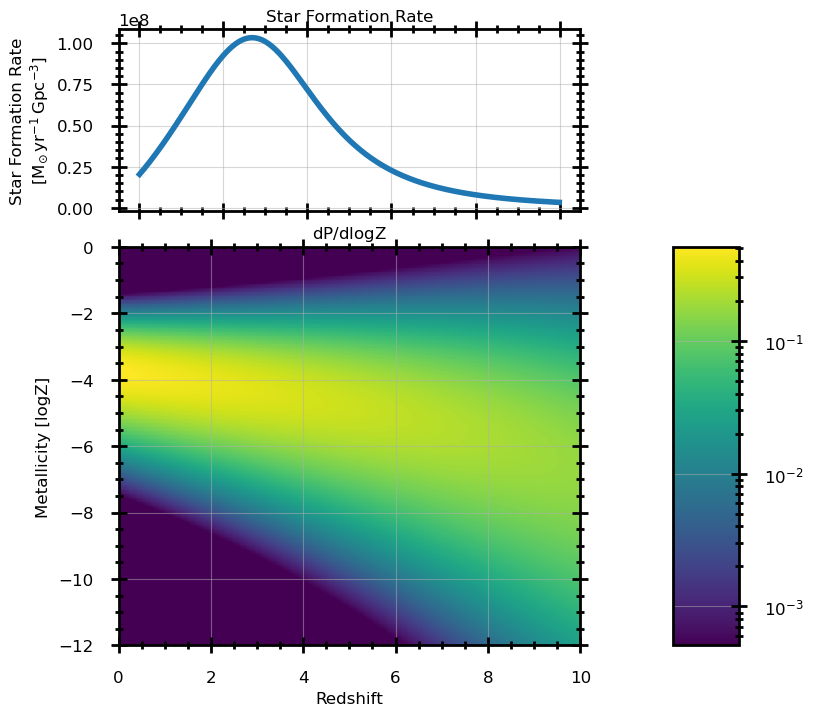

In [24]:
do_convolve_with_sfr_options(sfr_van_son['fiducial'])
# do_convolve_with_sfr_options(sfr_van_son['min'])
# do_convolve_with_sfr_options(sfr_van_son['max'])

In [10]:
def plot_merger_rate_from_hdf_file(options: SFROptions):
    with h5py.File(
            f'/Volumes/Elements/sspc_output_{str(options)}.h5', "r"
        ) as output_hdf5file:
            groupname = "output_data/example/conv_output/convolution_results/"
            # could try and make an actual merger plot. go through each key, sum the values
            yield_locations = output_hdf5file['output_data/example/conv_output/convolution_results/']
            
            merger_ax_lookbacks = []# np.zeros_like(list(yield_locations.keys()))
            
            # merger_ax_rates_total = []
            y_axis_units = u.Unit(extract_unit_dict(output_hdf5file, groupname + list(yield_locations.keys())[0])['yield']).to_string()

            # for each bin, we want a rate vs redshift
            for r, k in enumerate(yield_locations.keys()):
                # get number
                units = u.Quantity(k).unit
                assert units == u.Gyr, "Rest of plotting code assumes Gyr for lookback time. change conv settings"
                t = u.Quantity(k).value
                if u.Quantity(k) >= u.Quantity('14 Gyr'):
                    warnings.warn('Skipping a data point that was older than the universe..')
                    break
                merger_ax_lookbacks.append(t)
                # merger_ax_rates_total.append(np.sum(yield_locations[k]['yield'][()]))
                # we want to bin by metallicity
                # print(f'lookback: {t}, sum: {merger_ax_rates[r]}')
                # maybe we have to reweight the counts
                # yield_in_bin = yield_locations[k]['yield'][()]
                # counts, _ = np.histogram(yield_in_bin, weights=dco_mixture_weight)
                # merger_ax_rates[r] = np.sum(counts)
                # merger_ax[r].hist(
                #     yield_in_bin,
                #     weights=dco_mixture_weight,
                #     density=True
                # )
            # at this point we have the lookback times available that have also been filtered for unphysical time
            # now we can sort the times
            merger_ax_lookbacks = np.sort(np.array(merger_ax_lookbacks).astype(float))
            merger_rate_number_bins = 5 # keep this consistent for both metallicity and lookback
            _, merger_metallicity_bins = np.histogram(np.log10(dco_metallicities), bins=merger_rate_number_bins)
            merger_rates_binned_by_metallicities = np.zeros((len(merger_metallicity_bins), len(merger_ax_lookbacks)))
            # now the times are sorted, go through each lookback time, digitize on metallicity
            m_bin_indices = np.digitize(np.log10(dco_metallicities), merger_metallicity_bins)
            # get the dpdlogZ
            m_distro = options.calculate_metallicity_distro() # has same length as redshift bin_centers

            # now we'd also like to bin on delay times well
            # _, merger_delay_bins = np.histogram(delayTimes, bins=merger_rate_number_bins)
            # merger_rates_binned_by_delaytimes = np.zeros((len(merger_delay_bins), len(merger_ax_lookbacks)))
            # dt_bin_indices = np.digitize(delayTimes, merger_delay_bins)

            # we also want to get the rates_per_system so we can re-weight later on
            weights_at_z0 = np.zeros_like(dco_metallicities)

            for j, lo in enumerate(merger_ax_lookbacks):
                yields = yield_locations[u.Quantity(lo*u.Gyr).to_string()]['yield'][()]
                for bin_index in range(len(merger_metallicity_bins)):
                    # go through each bin, sum yields at the locations where the bin is equal
                    # this part is wrong! we want to use the metallicity distribution vs redshift
                    # metallicity_distro_at_cur_redshift = m_distro[
                    #     np.digitize(lookback_time_to_redshift(lo, Planck13).value, options.redshift_bin_centers) - 1
                    # ]
                    # # marginalize distro
                    # metallicity_distro_at_cur_redshift = metallicity_distro_at_cur_redshift / np.sum(metallicity_distro_at_cur_redshift)
                    # get expected count, weighted by probability from distribution
                    bin_query = np.where(m_bin_indices == bin_index+1) 
                    merger_rates_binned_by_metallicities[bin_index][j] = np.sum(
                        yields,
                        # weights=metallicity_distro_at_cur_redshift[
                        #     np.digitize(np.log10(dco_metallicities), options.log_metallicity_bin_centers)-1
                        # ][bin_query]
                    )
                    weights_at_z0 = weights_at_z0 + yields
                    # we want to plug in the metallicities to get the probability
                    # merger_rates_binned_by_delaytimes[bin_index][j] = np.sum(yields[np.where(dt_bin_indices == bin_index+1)])

            # merger_ax_rates_total = np.array(merger_ax_rates_total).astype(float)
            # assert 0
            merger_ax_lookbacks = [lookback_time_to_redshift(l, Planck13) for l in merger_ax_lookbacks]

            merger_metallicity_bins = np.round(merger_metallicity_bins,2)
            return {
                 'merger_rates_binned_by_metallicities': merger_rates_binned_by_metallicities,
                 'merger_metallicity_bins': merger_metallicity_bins,
                 'redshifts': np.round(merger_ax_lookbacks,2),
                 'y_units': y_axis_units,
                 'weights_at_current_z0': weights_at_z0
            }
    # if we could derive the detection probabilities (or really just use them using our data) then we can plot
    # the expected mergers with a confidence region
    # see this documentation from LIGO https://emfollow.docs.ligo.org/userguide/capabilities.html

fiducial_plotting_data = plot_merger_rate_from_hdf_file(sfr_van_son['fiducial'])
# min_plotting_data = plot_merger_rate_from_hdf_file(sfr_van_son['min'])
# max_plotting_data = plot_merger_rate_from_hdf_file(sfr_van_son['max'])

Plot by binning on metallicity

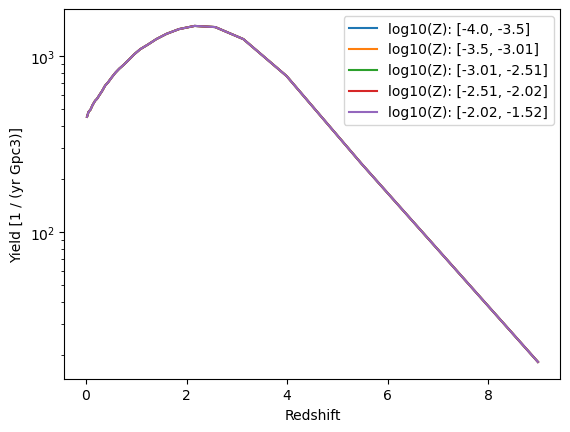

In [12]:
import matplotlib.ticker as mticker


merger_fig, merger_ax = plt.subplots(1, 1)
# merger_ax.set_ylim(np.min(merger_ax_rates), np.max(merger_ax_rates))
merger_ax.yaxis.set_inverted(False)  # ensure not inverted

# restore auto ticks/labels
merger_ax.yaxis.set_major_locator(mticker.AutoLocator()) #from GPT. something was wrong with matplotlib
merger_ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

# merger_ax.plot(
# np.round(fiducial_plotting_data['merger_ax_lookbacks'],2),
# np.sum(fiducial_plotting_data['merger_rates_binned_by_metallicities'],axis=0),
# label='Complete'
# )

for bi in range(fiducial_plotting_data['merger_rates_binned_by_metallicities'].shape[0]-1):     
    merger_ax.plot(
        np.round(fiducial_plotting_data['redshifts'],2),
        fiducial_plotting_data['merger_rates_binned_by_metallicities'][bi],
        label=f'log10(Z): [{fiducial_plotting_data['merger_metallicity_bins'][bi]}, {fiducial_plotting_data['merger_metallicity_bins'][bi+1]}]'
    )
    # merger_ax.plot(
    #     np.round(merger_ax_lookbacks,2),
    #     merger_rates_binned_by_delaytimes[bi],
    #     # label=f'log10(Z): [{merger_metallicity_bins[bi]}, {merger_metallicity_bins[bi+1]}]'
    # )
merger_ax.set_xlabel('Redshift')
# merger_ax.set_ylim(sorted(merger_ax.get_ylim()))
merger_ax.set_yscale('log')

merger_ax.set_ylabel(f'Yield [{fiducial_plotting_data['y_units']}]')
merger_ax.legend()
merger_fig.savefig('merger rates.png')


Do some plotting for different sfr information

/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_20483/2712690892.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sfr_fig.show()


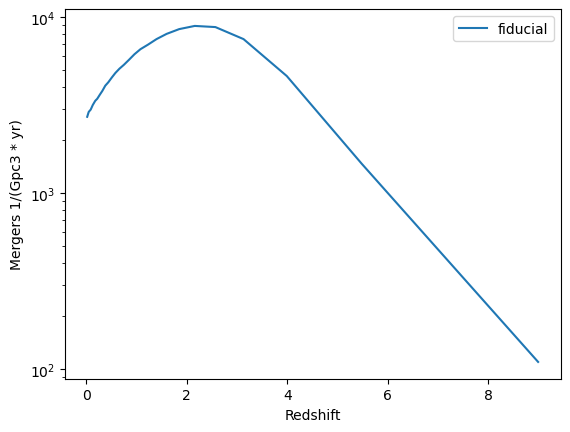

In [13]:

# make a new plot
sfr_fig, sfr_ax = plt.subplots(1, 1)

sfr_ax.plot(
    fiducial_plotting_data['redshifts'],
    np.sum(fiducial_plotting_data['merger_rates_binned_by_metallicities'],axis=0),
    label='fiducial'
)
# sfr_ax.plot(
#     min_plotting_data['redshifts'],
#     np.sum(min_plotting_data['merger_rates_binned_by_metallicities'],axis=0),
#     label='min'
# )
# sfr_ax.plot(
#     max_plotting_data['redshifts'],
#     np.sum(max_plotting_data['merger_rates_binned_by_metallicities'],axis=0),
#     label='max'
# )
sfr_ax.set_yscale('log')
sfr_ax.set_xlabel('Redshift')
sfr_ax.set_ylabel('Mergers 1/(Gpc3 * yr)')
sfr_ax.legend()
sfr_fig.show()

Plot on metallicities. Basically, sum the sfr on redshift then digitize it on the dco metallicities

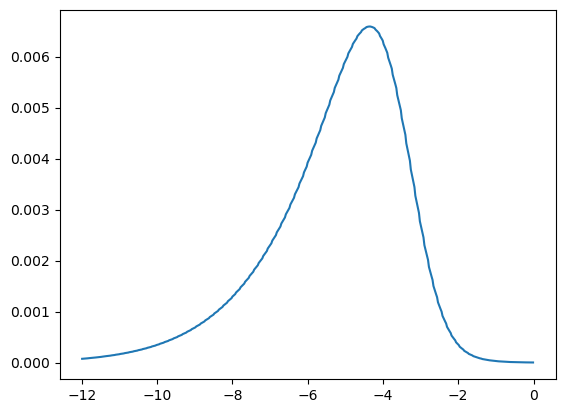

0.9999999999999993


/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_20483/777975020.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  met_fig.show()


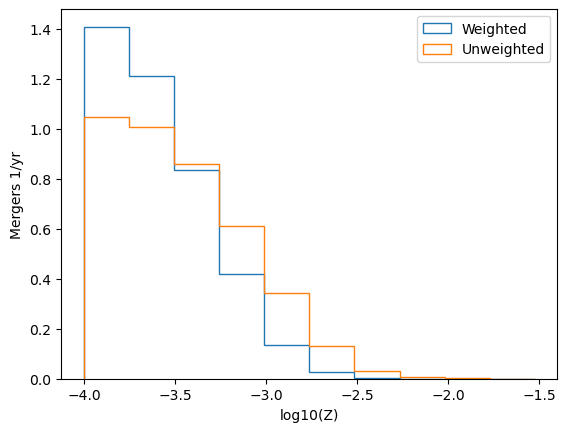

In [ ]:
model = 'fiducial'

marginal_met_distro = np.sum(sfr_van_son[model].calculate_metallicity_distro(),axis=0) # marginal metallicity distribution
plt.figure()
# np.sum(marginal_met_distro/np.sum(marginal_met_distro))
plt.plot(sfr_van_son[model].log_metallicity_bin_centers, marginal_met_distro/np.sum(marginal_met_distro))
# already an issue since pdf is not actually a pdf..although the form looks ok
# then again we're going to normalize anyway so the size of the weights won't matter
# plt.ylim(0,1)
plt.show()
# now we want to
met_fig, met_ax = plt.subplots(1,1)
weights_at_current_redshift = marginal_met_distro[np.digitize(np.log10(dco_metallicities),sfr_van_son[model].log_metallicity_bin_centers)-1]
# instead of weighting by the redshift, we really want to use the total rates
met_ax.hist(
    np.log10(dco_metallicities),
    weights=fiducial_plotting_data['weights_at_current_z0']/np.sum(fiducial_plotting_data['weights_at_current_z0']),
    density=True,
    label='Weighted',
    histtype='step'
)

met_ax.hist(
    np.log10(dco_metallicities),
    # weights=fiducial_plotting_data['weights_at_current_z0'],
    density=True,
    label='Unweighted',
    histtype='step'
)
met_ax.legend()
met_ax.set_xlabel('log10(Z)')
met_ax.set_ylabel('Mergers 1/yr')
met_fig.show()